In [190]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
import time

In [191]:
mx.set_default_device(mx.cpu)

mx.default_stream(mx.default_device())

Stream(Device(cpu, 0), 1)

In [192]:
def clamp(value: mx.array, min_value, max_value) -> mx.array:
    """
    Clamp a value to be within the range [min_value, max_value].

    Parameters:
    - value: The value to be clamped.
    - min_value: The minimum value of the range.
    - max_value: The maximum value of the range.

    Returns:
    The clamped value.
    """

    # return max(min_value, min(value, max_value))
    return mx.maximum(mx.minimum(value, max_value), min_value)
    # return mx.array([max(min_value, min(x, max_value)) for x in value])


In [193]:
class BitLinear(nn.Linear):
    """
    BitLinear is a custom linear layer that performs binarization of weights and quantization of activations
    in a group-wise manner.

    Args:
        in_features (int): Number of input features.
        out_features (int): Number of output features.
        bias (bool, optional): If set to False, the layer will not learn an additive bias. Default is True.
        num_groups (int, optional): Number of groups to divide the weights and activations into. Default is 1.
    """

    def __init__(self, input_dims: int, output_dims: int, bias: bool = True, num_groups: int = 1, b: int = 8):
        super().__init__(input_dims, output_dims, bias)

        self.input_dims = input_dims
        self.output_dims = output_dims
        self.num_groups = num_groups
        self.eps = 1e-5
        self.norm = nn.LayerNorm(input_dims)

        # Quantiziation and dequantization
        self.Q_b = 2 ** (b - 1)
        self.beta = mx.zeros((self.weight.shape[0],))
        self.gamma = mx.zeros((self.weight.shape[0],))

    def ste(self, x: mx.array):
        """
        Applies the sign function for binarization and uses Straight-Through Estimator (STE) during backward pass.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Binarized tensor.
        """
        # binarized_x = mx.array(map(x, lambda v: -1 if v <= 0 else 1))
        # binarized_x[binarized_x == 0] = -1
        # Straight-THrough Estimator for backward pass
        # TODO: this is not differentiable so does not work for training!
        # The workaround in pytorch is below (use detach for Straight-Through Estimator during backprop)
        # binarized_x = (binarized_x - x).detach() + x
        # binarized_x = binarized_x - x
        # mx.stop_gradient(binarized_x)
        # binarized_x = binarized_x + x
        # binarized_x = mx.stop_gradient(binarized_x - x) + x

        print(mx.where(x <= 0, -1 * mx.ones_like(x), mx.ones_like(x)))
        return mx.where(x <= 0, -1 * mx.ones_like(x), mx.ones_like(x))
        # return mx.array([-1 if v <= 0 else 1 for v in x])

    def binarize_weights_groupwise(self):
        """
        Binarizes the weights of the layer in a group-wise manner using STE.

        Returns:
            Tensor: Binarized weights tensor.
        """
        group_size = self.weight.shape[0] // self.num_groups
        binarized_weights = mx.zeros_like(self.weight)

        for g in range(self.num_groups):
            start_idx = g * group_size
            end_idx = (g + 1) * group_size
            print(f"{start_idx=}, {end_idx=}")
            weight_group = self.weight[start_idx:end_idx]
            alpha_g = weight_group.mean()
            self.beta[start_idx:end_idx] = weight_group.abs().mean()
            print("binarized weights before ste:")
            for i in range(start_idx, end_idx):
                print(i, binarized_weights[i])
            binarized_weights[start_idx:end_idx] = self.ste(weight_group - alpha_g)

            for i in range(end_idx - start_idx):
                binarized_weights[i + start_idx] = self.ste(weight_group - alpha_g)[i]

            print("weight before ste:")
            for i in range(len(self.weight)):
                print(self.weight[i])
            print("weight_group before ste:")
            for i in range(end_idx - start_idx):
                print(weight_group[i])
            print("alpha_g before ste:")
            print(alpha_g)
            print("before ste diff:")
            for i in range(end_idx - start_idx):
                print(i, (weight_group - alpha_g)[i])
            print("after ste diff:")
            for i in range(end_idx - start_idx):
                print(i, self.ste(weight_group - alpha_g)[i])
            print("binarized weights after ste:")
            for i in range(start_idx, end_idx):
                print(i, binarized_weights[i])

        return binarized_weights

    def quantize_activations_groupwise(self, x):
        """
        Quantizes the activations of the layer in a group-wise manner.

        Args:
            x (Tensor): Input tensor.
            b (int, optional): Number of bits for quantization. Default is 8.

        Returns:
            Tensor: Quantized activations tensor.
        """
        group_size = x.shape[0] // self.num_groups
        quantized_x = mx.zeros_like(x)

        for g in range(self.num_groups):
            start_idx = g * group_size
            end_idx = (g + 1) * group_size
            activation_group = x[start_idx:end_idx]

            gamma_g = activation_group.abs().max()
            print(f"{activation_group=} {gamma_g=}")
            self.gamma[start_idx:end_idx] = gamma_g
            quantized_x[start_idx:end_idx] = clamp(
                activation_group * self.Q_b / (gamma_g + self.eps),
                -self.Q_b + self.eps,
                self.Q_b - self.eps,
            )

        return quantized_x

    def dequantize_activations_groupwise(self, x):
        """
        Dequantizes the activations of the layer in a group-wise manner.

        Args:
            x (Tensor): Quantized input tensor.

        Returns:
            Tensor: Dequantized activations tensor.
        """

        print(f"dequantize: {x} * {self.gamma} * {self.beta} / {self.Q_b} = {x * self.gamma * self.beta / self.Q_b}")
        return x * self.gamma * self.beta / self.Q_b


    def __call__(self, x: mx.array) -> mx.array:
        # print(f"normalize: {x}")
        # x = self.norm(x)
        # print(f"normalized to: {x}")

        # Binarize weights and quantize activations
        binarized_weights = self.binarize_weights_groupwise()

        print(f"result of binarized_weights:")
        print(binarized_weights)

        # Quantize input
        x_quant = self.quantize_activations_groupwise(x)

        print(f"quantized input: {x=} to {x_quant=}")


        # Perform linear transformation
        # output = nn.functional.linear(x_quant, binarized_weights, self.bias)
        if "bias" in self:
            output = mx.addmm(self.bias, x_quant, binarized_weights.T)
        else:
            output = x_quant @ binarized_weights.T

        print("x_quant:")
        print(x_quant)
        print("binarized_weights.T:")
        print(binarized_weights.T)
        print("output:")
        print(output)
        print(f"{x_quant=} @ {binarized_weights.T=} = {output}")

        # Dequantize activations
        output = self.dequantize_activations_groupwise(output)

        print(f"dequantized output: {output}")

        # Return output
        return output

In [194]:
mx.sign(mx.array([-1,-5,0,1,2]))

array([-1, -1, 0, 1, 1], dtype=int32)

In [195]:
# benchmark BitLinear
iterations = 20

bl = BitLinear(512, 256, bias=False)

# prepare inputs
xs = [mx.random.uniform(shape=(512,)) for _ in range(iterations)]

start_time = time.time()
for i in range(iterations):
    x = xs[i]
    y = bl(x)
    print(y.sum())

end_time = time.time()
elapsed = end_time - start_time
print(f"elapsed: {elapsed}s")



start_idx=0, end_idx=256
binarized weights before ste:
0 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
1 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
2 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
3 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
4 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
5 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
6 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
7 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
8 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
9 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
10 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
11 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
12 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
13 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
14 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
15 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
16 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
17 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
18 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
19 array([0, 0, 0, ..., 

In [196]:
# benchmark QuantizedLinear
iterations = 20

ql = nn.QuantizedLinear(512, 256, bias=False)

# prepare inputs
xs = [mx.random.uniform(shape=(512,)) for _ in range(iterations)]

start_time = time.time()
for i in range(iterations):
    x = xs[i]
    y = ql(x)
    print(y.sum())

end_time = time.time()
elapsed = end_time - start_time
print(f"elapsed: {elapsed}s")



array(4.72093, dtype=float32)
array(0.311543, dtype=float32)
array(2.17134, dtype=float32)
array(-0.0253518, dtype=float32)
array(0.223571, dtype=float32)
array(4.14859, dtype=float32)
array(3.30684, dtype=float32)
array(4.86361, dtype=float32)
array(0.363436, dtype=float32)
array(2.09201, dtype=float32)
array(1.14925, dtype=float32)
array(5.41352, dtype=float32)
array(3.42353, dtype=float32)
array(0.977476, dtype=float32)
array(0.925495, dtype=float32)
array(0.881361, dtype=float32)
array(0.713508, dtype=float32)
array(0.517731, dtype=float32)
array(3.26607, dtype=float32)
array(-2.9369, dtype=float32)
elapsed: 0.006861209869384766s


In [197]:

class BitBlock(nn.Module):
    def __init__(self, input_dims, output_dims):
        super().__init__()
        self.layers = [
            BitLinear(input_dims, output_dims),
            nn.GELU()
        ]
    
    def __call__(self, x):
        for l in self.layers:
            print(f"Before: {x}")
            x = l(x)
            print(f"After: {x}")
            if "weight" in l:
                print(f"Weights: {l.weight}")

        return x

class BitModel(nn.Module):
    def __init__(self, num_layers, input_dims, output_dims, hidden_dims = 128):
        super().__init__()
        self.layers = [
            BitBlock(
                input_dims if i == 0 else hidden_dims, output_dims if i == num_layers-1 else hidden_dims
            )
            for i in range(num_layers)
        ]
        print(self.layers)

    def __call__(self, x):
        for l in self.layers:
            x = l(x)

        return x

class StandardBlock(nn.Module):
    def __init__(self, input_dims, output_dims):
        super().__init__()
        self.layers = [
            nn.Linear(input_dims, output_dims),
            nn.GELU()
        ]
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
            # if "weight" in l:
            #     print(l.weight)

        return x

class StandardModel(nn.Module):
    def __init__(self, num_layers, input_dims, output_dims, hidden_dims = 128):
        super().__init__()
        self.layers = [
            StandardBlock(
                input_dims if i == 0 else hidden_dims, output_dims if i == num_layers-1 else hidden_dims
            )
            for i in range(num_layers)
        ]
        print(self.layers)

    def __call__(self, x):
        for l in self.layers:
            x = l(x)

        return x


model = BitModel(2, 8, 1, hidden_dims=8)
# model = StandardModel(2, 1, 1)
# y = model(mx.array([2]))
# print(f"{y=}")

# y = bl(mx.random.uniform(shape=(512,)))
# print(y)

def loss_fn(model, inputs, targets):
    predictions = model(inputs)
    return nn.losses.mse_loss(predictions, targets)

optimizer = optim.AdamW(
    learning_rate=0.01
)


def step(inputs, targets):
    loss_and_grad_fn = nn.value_and_grad(model, loss_fn)
    loss, grads = loss_and_grad_fn(model, inputs, targets)
    optimizer.update(model, grads)
    return loss


[BitBlock(
  (layers.0): BitLinear(input_dims=8, output_dims=8, bias=True
    (norm): LayerNorm(8, eps=1e-05, affine=True)
  )
  (layers.1): GELU()
), BitBlock(
  (layers.0): BitLinear(input_dims=8, output_dims=1, bias=True
    (norm): LayerNorm(8, eps=1e-05, affine=True)
  )
  (layers.1): GELU()
)]


In [198]:
import numpy as np

state = [model.state, optimizer.state]

# points_to_predict = [(0, 0), (1, 1) , (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7)]
points_to_predict = [(random_floats := np.random.rand(8), np.sum(random_floats)) for _ in range(10)]
points_to_predict = [(mx.array(array), sum_) for array, sum_ in points_to_predict]


def run_predictions():
    for (x, y) in points_to_predict:
        print(f"{x} -> (predicted: {model(x)}, actual: {y})")

run_predictions()

print(model.layers[0].layers[0].weight)

losses = []
for _ in range(100):
    loss = step(mx.array([x for (x, y) in points_to_predict]), mx.array([mx.array([y]) for (x, y) in points_to_predict]))
    print(f"{loss.item()=}")
    losses.append(loss.item())
    # mx.eval(state)

print(model.layers[0].layers[0].weight)


run_predictions()




Before: array([0.876794, 0.894659, 0.356305, ..., 0.430995, 0.985413, 0.330111], dtype=float32)
start_idx=0, end_idx=8
binarized weights before ste:
0 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
1 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
2 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
3 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
4 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
5 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
6 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
7 array([0, 0, 0, ..., 0, 0, 0], dtype=float32)
array([[-1, 1, 1, ..., 1, 1, -1],
       [1, 1, -1, ..., 1, 1, 1],
       [-1, -1, -1, ..., -1, 1, 1],
       ...,
       [1, -1, -1, ..., 1, -1, -1],
       [-1, -1, 1, ..., 1, 1, -1],
       [1, -1, -1, ..., 1, 1, 1]], dtype=float32)
array([[-1, 1, 1, ..., 1, 1, -1],
       [1, 1, -1, ..., 1, 1, 1],
       [-1, -1, -1, ..., -1, 1, 1],
       ...,
       [1, -1, -1, ..., 1, -1, -1],
       [-1, -1, 1, ..., 1, 1, -1],
       [1, -1, -1, ..., 1, 1, 1]], dtype=floa

[16.005762100219727, 16.01691246032715, 16.001317977905273, 16.12703514099121, 16.197256088256836, 16.155609130859375, 16.066049575805664, 16.370563507080078, 16.33656883239746, 16.327835083007812, 16.302339553833008, 16.32784080505371, 16.368024826049805, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


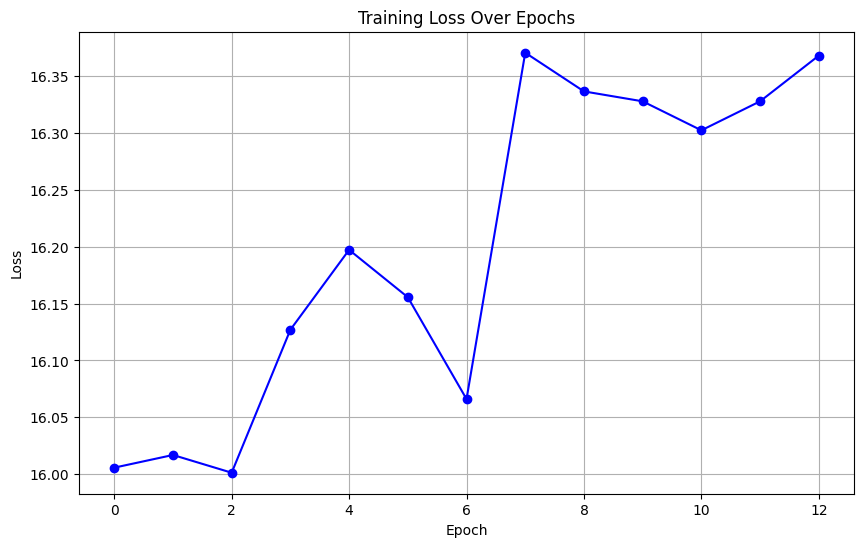

In [199]:
import matplotlib.pyplot as plt


print(losses[0:100])
# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()